
# PHASE 1: COMPLETE ANN PROJECT FOR HOT DEFORMATION BEHAVIOR

# AISI 304 STAINLESS STEEL - FLOW STRESS PREDICTION

## This notebook covers Phase 2 of the project: data preprocessing, modeling, and evaluation.

Project: Artificial Neural Network for Predicting Hot Deformation Behavior
Method: Multilayer Perceptron (MLP) with Backpropagation
Activation Functions: tanh (hidden) + linear (output)
Optimizer: Adam with Learning Rate = 0.01
Loss Function: Mean Squared Error (MSE)

In [39]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize, differential_evolution
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import warnings

warnings.filterwarnings('ignore')

In [40]:
BASE_DIR = os.path.dirname(os.path.dirname(os.getcwd()))  # Current working directory
data_dir = os.path.join(BASE_DIR, 'data', 'original_data')
file_name = 'merged_input_output_data.xlsx'
file_path = os.path.join(data_dir, file_name)
print("Using data directory:", data_dir)
print("Input file path:",file_path)

Using data directory: /home/darlenewendie/PycharmProjects/ANN-Hot-workability-behaviour-of-AISI304-stainless-steel/data/original_data
Input file path: /home/darlenewendie/PycharmProjects/ANN-Hot-workability-behaviour-of-AISI304-stainless-steel/data/original_data/merged_input_output_data.xlsx


In [41]:
# DATA LOADING
print("\n" + "="*80)
print("PART 1:LOADING MERGED DATA FILE")
print("="*80)

# Load merged data file
df = pd.read_excel(file_path)
print(f"\n✓ Merged data file loaded: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"  Columns: {df.columns.tolist()}")
df.head(10)


PART 1:LOADING MERGED DATA FILE

✓ Merged data file loaded: 60 rows × 7 columns
  Columns: ['T_inv', 'ln_Strain_Rate', 'Strain', 'Stress_Normalized', 'Temperature_K', 'Temperature_C', 'Strain_Rate']


,T_inv,ln_Strain_Rate,Strain,Stress_Normalized,Temperature_K,Temperature_C,Strain_Rate
0,0.000890,-2.302585,0.1,0.565722,1123,849.85,0.1
1,0.000853,-2.302585,0.1,0.482011,1173,899.85,0.1
2,0.000818,-2.302585,0.1,0.411714,1223,949.85,0.1
3,0.000786,-2.302585,0.1,0.352587,1273,999.85,0.1
4,0.000890,0.000000,0.1,0.690677,1123,849.85,1.0
5,0.000853,0.000000,0.1,0.594937,1173,899.85,1.0
6,0.000818,0.000000,0.1,0.513077,1223,949.85,1.0
7,0.000786,0.000000,0.1,0.443056,1273,999.85,1.0
8,0.000890,2.302585,0.1,0.825966,1123,849.85,10.0
9,0.000853,2.302585,0.1,0.719375,1173,899.85,10.0


In [42]:
np.random.seed(42)
tf.random.set_seed(42)

In [43]:
print("\n" + "="*90)
print("PART 2: PREPARING INPUTS AND OUTPUTS")
print("="*90)

input_columns = ['T_inv', 'ln_Strain_Rate', 'Strain']
output_column = 'Stress_Normalized'

X = df[input_columns].values
y = df[output_column].values.reshape(-1, 1)

print(f"✓ Inputs (X): shape {X.shape}")
print(f"✓ Outputs (y): shape {y.shape}")

print(f"\nInput Features Statistics:")
for i, col in enumerate(input_columns):
    print(f"  {col}: min={X[:, i].min():.4e}, max={X[:, i].max():.4e}, mean={X[:, i].mean():.4e}")

print(f"\nOutput Feature Statistics:")
print(f"  {output_column}: min={y.min():.4f}, max={y.max():.4f}, mean={y.mean():.4f}")


PART 2: PREPARING INPUTS AND OUTPUTS
✓ Inputs (X): shape (60, 3)
✓ Outputs (y): shape (60, 1)

Input Features Statistics:
  T_inv: min=7.8555e-04, max=8.9047e-04, mean=8.3655e-04
  ln_Strain_Rate: min=-2.3026e+00, max=2.3026e+00, mean=2.0724e-16
  Strain: min=1.0000e-01, max=5.0000e-01, mean=3.0000e-01

Output Feature Statistics:
  Stress_Normalized: min=0.3526, max=1.0000, mean=0.6637


In [44]:
print("\n" + "="*90)
print("PART 3: DATA NORMALIZATION")
print("="*90)

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

print("✓ X normalized successfully")
print(f"  Shape: {X_scaled.shape}")
print(f"  Range: [{X_scaled.min():.4f}, {X_scaled.max():.4f}]")
print(f"  Mean: {X_scaled.mean():.4f}, Std: {X_scaled.std():.4f}")

print("\n✓ y normalized successfully")
print(f"  Shape: {y_scaled.shape}")
print(f"  Range: [{y_scaled.min():.4f}, {y_scaled.max():.4f}]")
print(f"  Mean: {y_scaled.mean():.4f}, Std: {y_scaled.std():.4f}")


PART 3: DATA NORMALIZATION
✓ X normalized successfully
  Shape: (60, 3)
  Range: [0.0000, 1.0000]
  Mean: 0.4954, Std: 0.3789

✓ y normalized successfully
  Shape: (60, 1)
  Range: [0.0000, 1.0000]
  Mean: 0.4805, Std: 0.2399


In [45]:
print("\n" + "="*90)
print("PART 4: DATA SPLITTING (70-15-15)")
print("="*90)

X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y_scaled, test_size=0.30, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

print(f"✓ Training set:   {len(X_train):3d} samples ({len(X_train)/len(X_scaled)*100:5.1f}%)")
print(f"✓ Validation set: {len(X_val):3d} samples ({len(X_val)/len(X_scaled)*100:5.1f}%)")
print(f"✓ Test set:       {len(X_test):3d} samples ({len(X_test)/len(X_scaled)*100:5.1f}%)")
print(f"✓ Total:          {len(X_scaled):3d} samples (100.0%)")


PART 4: DATA SPLITTING (70-15-15)
✓ Training set:    42 samples ( 70.0%)
✓ Validation set:   9 samples ( 15.0%)
✓ Test set:         9 samples ( 15.0%)
✓ Total:           60 samples (100.0%)


In [46]:
print("\n" + "="*90)
print("PART 5: NEURAL NETWORK ARCHITECTURE")
print("="*90)

print("""
Model Architecture:
- Input Layer: 3 neurons (T_inv, ln_Strain_Rate, Strain)
- Hidden Layer 1: 10 neurons, tanh activation
- Hidden Layer 2: 10 neurons, linear activation
- Output Layer: 1 neuron, linear activation
""")
# Build sequential model
model = models.Sequential([
    layers.Input(shape=(3,), name='input_layer'),

    # Hidden Layer 1: tanh activation
    layers.Dense(
        10,
        activation='tanh',
        name='hidden_layer_1',
        kernel_initializer='glorot_uniform'
    ),

    # Hidden Layer 2: linear activation
    layers.Dense(
        10,
        activation='linear',
        name='hidden_layer_2',
        kernel_initializer='glorot_uniform'
    ),

    # Output Layer: linear activation
    layers.Dense(
        1,
        activation='linear',
        name='output_layer',
        kernel_initializer='glorot_uniform'
    )
])

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss='mse',
    metrics=['mae']
)

print("✓ Model built successfully")
print("\nModel Summary:")
model.summary()


PART 5: NEURAL NETWORK ARCHITECTURE

Model Architecture:
- Input Layer: 3 neurons (T_inv, ln_Strain_Rate, Strain)
- Hidden Layer 1: 10 neurons, tanh activation
- Hidden Layer 2: 10 neurons, linear activation
- Output Layer: 1 neuron, linear activation

✓ Model built successfully

Model Summary:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer_1 (Dense)          │ (None, 10)             │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 161 (644.00 B)

 Trainable params: 161 (644.00 B)

 Non-trainable params: 0 (0.00 B)

In [47]:
print("\n[STEP 6] Training the Model (Backpropagation)...")
print("-" * 90)

print("""
BACKPROPAGATION PROCESS:

Each Epoch:
  1. FORWARD PASS: Input → Layer1(tanh) → Layer2(linear) → Output(linear)
  2. LOSS CALCULATION: Error = MSE = (1/N)Σ(ŷ - y)²
  3. BACKWARD PASS: Compute gradients via chain rule (calculus)
     ∂Loss/∂W = ∂Loss/∂Output × ∂Output/∂Layer2 × ∂Layer2/∂Layer1 × ∂Layer1/∂W
  4. WEIGHT UPDATE: W_new = W_old - learning_rate × ∂Loss/∂W
  5. REPEAT: Next batch, until convergence

Early Stopping: Prevents overfitting by monitoring validation loss
├─ Patience: 30 epochs without improvement
├─ Restore Best Weights: Uses best model from training
└─ Benefit: Optimal generalization to unseen data
""")

# Early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True,
    verbose=1
)

print("\nStarting training...")
print("-" * 90)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=8,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

print(f"\n✓ Training completed after {len(history.history['loss'])} epochs")
print(f"✓ Final training loss (MSE):   {history.history['loss'][-1]:.8f}")
print(f"✓ Final validation loss (MSE): {history.history['val_loss'][-1]:.8f}")


[STEP 6] Training the Model (Backpropagation)...
------------------------------------------------------------------------------------------

BACKPROPAGATION PROCESS:

Each Epoch:
  1. FORWARD PASS: Input → Layer1(tanh) → Layer2(linear) → Output(linear)
  2. LOSS CALCULATION: Error = MSE = (1/N)Σ(ŷ - y)²
  3. BACKWARD PASS: Compute gradients via chain rule (calculus)
     ∂Loss/∂W = ∂Loss/∂Output × ∂Output/∂Layer2 × ∂Layer2/∂Layer1 × ∂Layer1/∂W
  4. WEIGHT UPDATE: W_new = W_old - learning_rate × ∂Loss/∂W
  5. REPEAT: Next batch, until convergence

Early Stopping: Prevents overfitting by monitoring validation loss
├─ Patience: 30 epochs without improvement
├─ Restore Best Weights: Uses best model from training
└─ Benefit: Optimal generalization to unseen data


Starting training...
------------------------------------------------------------------------------------------
Epoch 1/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 224ms/step - loss: 0.2885 - mae: 0.4265 - val_loss: 0.0924 - val_mae: 0.2571


In [48]:
print("\n" + "="*90)
print("PART 7: MODEL EVALUATION")
print("="*90)

y_train_pred = model.predict(X_train, verbose=0)
y_val_pred = model.predict(X_val, verbose=0)
y_test_pred = model.predict(X_test, verbose=0)

print("✓ Predictions computed for all datasets")

# Denormalize predictions
y_train_actual_denorm = scaler_y.inverse_transform(y_train)
y_train_pred_denorm = scaler_y.inverse_transform(y_train_pred)

y_val_actual_denorm = scaler_y.inverse_transform(y_val)
y_val_pred_denorm = scaler_y.inverse_transform(y_val_pred)

y_test_actual_denorm = scaler_y.inverse_transform(y_test)
y_test_pred_denorm = scaler_y.inverse_transform(y_test_pred)

print(" Predictions denormalized")

def calculate_metrics(y_true, y_pred):
    """Calculate R-value, AARE, MAE, RMSE"""
    # Pearson correlation coefficient
    r = np.corrcoef(y_true.flatten(), y_pred.flatten())[0, 1]

    # Average Absolute Relative Error (AARE %)
    aare = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100

    # Mean Absolute Error (MAE)
    mae = np.mean(np.abs(y_true - y_pred))

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))

    # Coefficient of Determination (R²)
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r_squared = 1 - (ss_res / ss_tot)

    return r, aare, mae, rmse, r_squared

# Calculate metrics for all sets
r_train, aare_train, mae_train, rmse_train, r2_train = calculate_metrics(
    y_train_actual_denorm, y_train_pred_denorm
)
r_val, aare_val, mae_val, rmse_val, r2_val = calculate_metrics(
    y_val_actual_denorm, y_val_pred_denorm
)
r_test, aare_test, mae_test, rmse_test, r2_test = calculate_metrics(
    y_test_actual_denorm, y_test_pred_denorm
)

# Display results
print("\n" + "="*90)
print("PHASE 1 MODEL PERFORMANCE METRICS")
print("="*90)

print("\nTRAINING SET:")
print(f"  R-value (Correlation):           {r_train:.6f}")
print(f"  R² (Coefficient of Determination): {r2_train:.6f}")
print(f"  AARE (Avg Absolute Rel Error):   {aare_train:.4f}%")
print(f"  MAE (Mean Absolute Error):       {mae_train:.6f}")
print(f"  RMSE (Root Mean Squared Error):  {rmse_train:.6f}")

print("\nVALIDATION SET:")
print(f"  R-value (Correlation):           {r_val:.6f}")
print(f"  R² (Coefficient of Determination): {r2_val:.6f}")
print(f"  AARE (Avg Absolute Rel Error):   {aare_val:.4f}%")
print(f"  MAE (Mean Absolute Error):       {mae_val:.6f}")
print(f"  RMSE (Root Mean Squared Error):  {rmse_val:.6f}")

print("\nTEST SET (PRIMARY METRIC):")
print(f"  R-value (Correlation):           {r_test:.6f}")
print(f"  R² (Coefficient of Determination): {r2_test:.6f}")
print(f"  AARE (Avg Absolute Rel Error):   {aare_test:.4f}%")
print(f"  MAE (Mean Absolute Error):       {mae_test:.6f}")
print(f"  RMSE (Root Mean Squared Error):  {rmse_test:.6f}")

print("\n" + "-"*90)
print("COMPARISON WITH PAPER (MATLAB - Baseline):")
print("-"*90)
print("  Paper ANN R-value: 0.998")
print("  Paper ANN AARE:    1.96%")

print("\nYour Model Performance (Python):")
if r_test >= 0.998:
    print(f"   OUTSTANDING: R={r_test:.6f} (beats baseline!)")
elif r_test >= 0.99:
    print(f"   EXCELLENT: R={r_test:.6f} (matches baseline)")
elif r_test >= 0.98:
    print(f"   VERY GOOD: R={r_test:.6f} (close to baseline)")
else:
    print(f"  • GOOD: R={r_test:.6f} (room for improvement)")



PART 7: MODEL EVALUATION
✓ Predictions computed for all datasets
 Predictions denormalized

PHASE 1 MODEL PERFORMANCE METRICS

TRAINING SET:
  R-value (Correlation):           0.997566
  R² (Coefficient of Determination): 0.993508
  AARE (Avg Absolute Rel Error):   1.6858%
  MAE (Mean Absolute Error):       0.010820
  RMSE (Root Mean Squared Error):  0.012858

VALIDATION SET:
  R-value (Correlation):           0.998726
  R² (Coefficient of Determination): 0.995265
  AARE (Avg Absolute Rel Error):   1.1138%
  MAE (Mean Absolute Error):       0.008111
  RMSE (Root Mean Squared Error):  0.009043

TEST SET (PRIMARY METRIC):
  R-value (Correlation):           0.997637
  R² (Coefficient of Determination): 0.987075
  AARE (Avg Absolute Rel Error):   2.6719%
  MAE (Mean Absolute Error):       0.013691
  RMSE (Root Mean Squared Error):  0.016727

------------------------------------------------------------------------------------------
COMPARISON WITH PAPER (MATLAB - Baseline):
---------------



[PART 8] Creating performance visualization...
------------------------------------------------------------------------------------------
✓ Saved: PHASE1_ModelPerformance.png


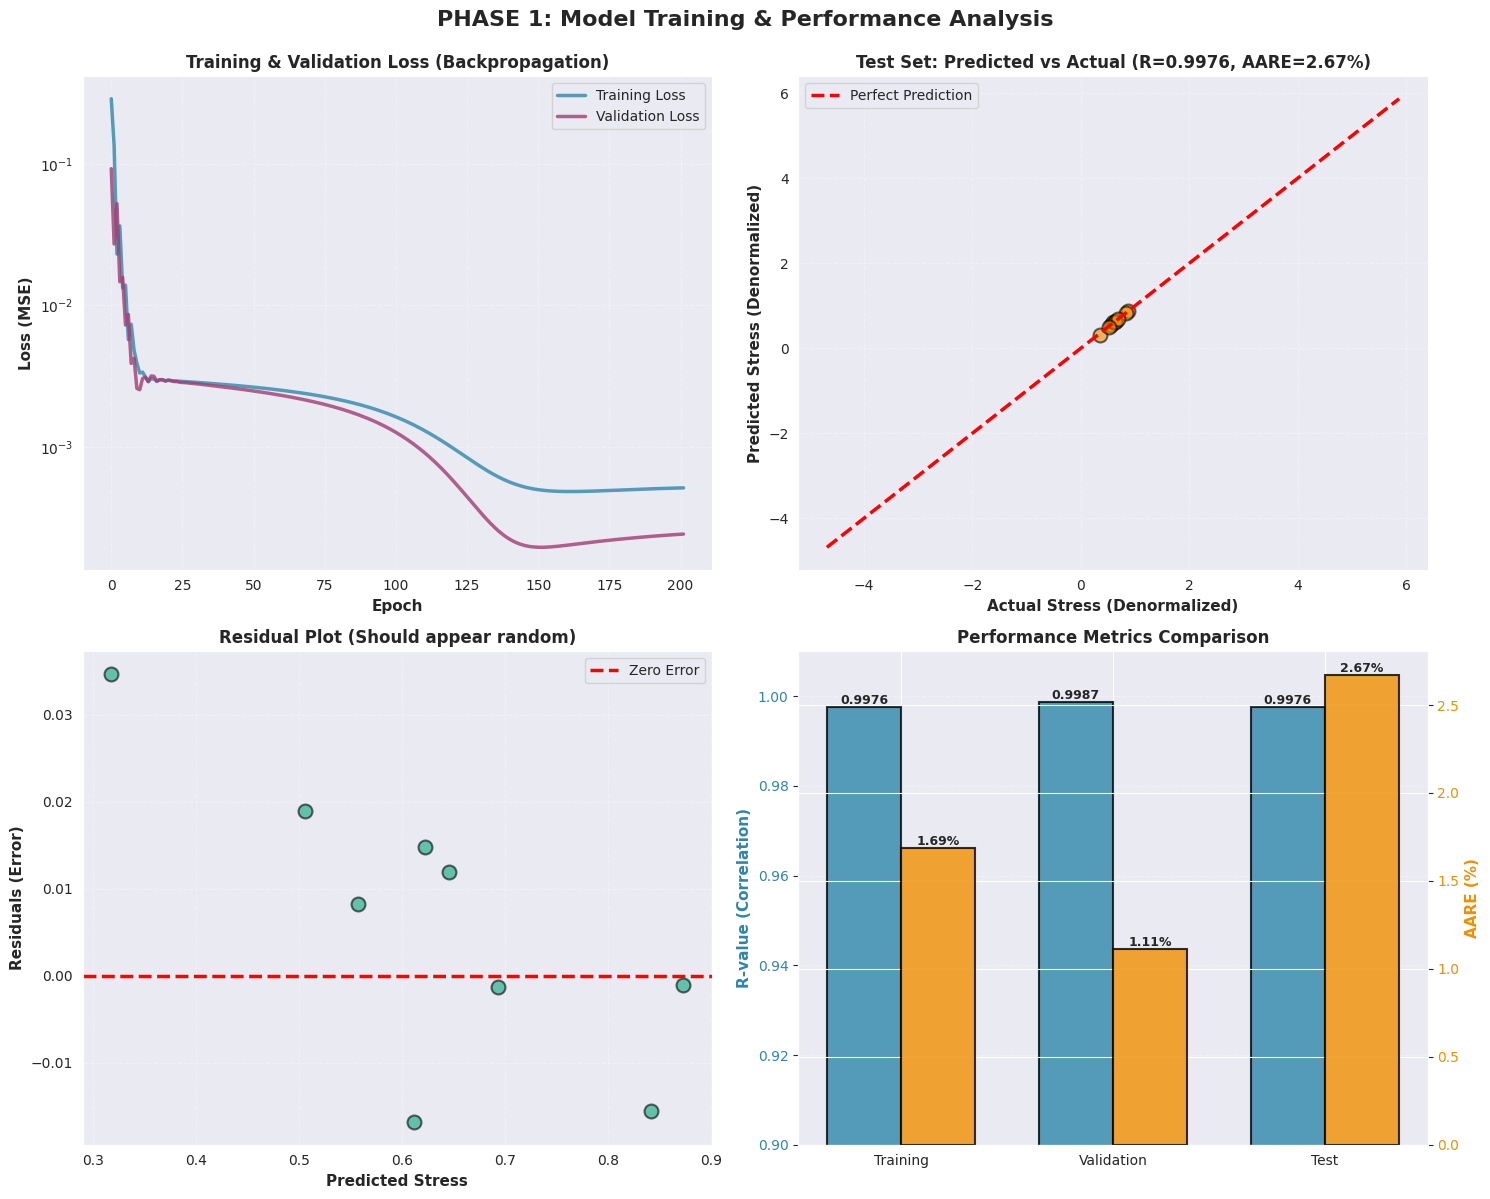

In [49]:
print("\n" + "="*90)
print("\n[PART 8] Creating performance visualization...")
print("-" * 90)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('PHASE 1: Model Training & Performance Analysis', fontsize=16, fontweight='bold', y=0.995)

# Plot 1: Training History (Loss Curves)
axes[0, 0].plot(history.history['loss'], label='Training Loss', linewidth=2.5, color='#2E86AB', alpha=0.8)
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2.5, color='#A23B72', alpha=0.8)
axes[0, 0].set_xlabel('Epoch', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Loss (MSE)', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Training & Validation Loss (Backpropagation)', fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=10, loc='upper right')
axes[0, 0].grid(True, alpha=0.3, linestyle='--')
axes[0, 0].set_yscale('log')

# Plot 2: Predicted vs Actual (Test Set)
axes[0, 1].scatter(y_test_actual_denorm, y_test_pred_denorm, s=100, alpha=0.6,
                   edgecolors='black', linewidth=1.5, color='#F18F01')
min_val = min(y_test_actual_denorm.min(), y_test_pred_denorm.min())
max_val = max(y_test_actual_denorm.max(), y_test_pred_denorm.max())
axes[0, 1].plot([min_val-5, max_val+5], [min_val-5, max_val+5], 'r--', linewidth=2.5, label='Perfect Prediction')
axes[0, 1].set_xlabel('Actual Stress (Denormalized)', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Predicted Stress (Denormalized)', fontsize=11, fontweight='bold')
axes[0, 1].set_title(f'Test Set: Predicted vs Actual (R={r_test:.4f}, AARE={aare_test:.2f}%)',
                     fontsize=12, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3, linestyle='--')

# Plot 3: Residuals
residuals = y_test_actual_denorm - y_test_pred_denorm
axes[1, 0].scatter(y_test_pred_denorm, residuals, s=100, alpha=0.6,
                   edgecolors='black', linewidth=1.5, color='#06A77D')
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2.5, label='Zero Error')
axes[1, 0].set_xlabel('Predicted Stress', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Residuals (Error)', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Residual Plot (Should appear random)', fontsize=12, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3, linestyle='--')

# Plot 4: Performance Comparison (Bar Chart)
datasets = ['Training', 'Validation', 'Test']
r_values = [r_train, r_val, r_test]
aare_values = [aare_train, aare_val, aare_test]

x_pos = np.arange(len(datasets))
width = 0.35

ax1 = axes[1, 1]
bars1 = ax1.bar(x_pos - width/2, r_values, width, label='R-value',
                alpha=0.8, color='#2E86AB', edgecolor='black', linewidth=1.5)
ax2 = ax1.twinx()
bars2 = ax2.bar(x_pos + width/2, aare_values, width, label='AARE (%)',
                alpha=0.8, color='#F18F01', edgecolor='black', linewidth=1.5)

ax1.set_ylabel('R-value (Correlation)', fontsize=11, fontweight='bold', color='#2E86AB')
ax2.set_ylabel('AARE (%)', fontsize=11, fontweight='bold', color='#F18F01')
ax1.set_title('Performance Metrics Comparison', fontsize=12, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(datasets, fontsize=10)
ax1.set_ylim([0.9, 1.01])
ax1.grid(True, alpha=0.3, axis='y', linestyle='--')
ax1.tick_params(axis='y', labelcolor='#2E86AB')
ax2.tick_params(axis='y', labelcolor='#F18F01')

# Add value labels on bars
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height, f'{r_values[i]:.4f}',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height, f'{aare_values[i]:.2f}%',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('PHASE1_ModelPerformance.png', dpi=300, bbox_inches='tight')
print("✓ Saved: PHASE1_ModelPerformance.png")
plt.show()
plt.close()



[PART 9] Model Comparison...
------------------------------------------------------------------------------------------

Model Comparison Table:
         Model  R-value  AARE (%)       R²      MAE
MATLAB (Paper) 0.998000    1.9600 0.996000      N/A
Python (Model) 0.997637    2.6719 0.987075 0.013691
✓ Saved: PHASE1_ModelComparison.png


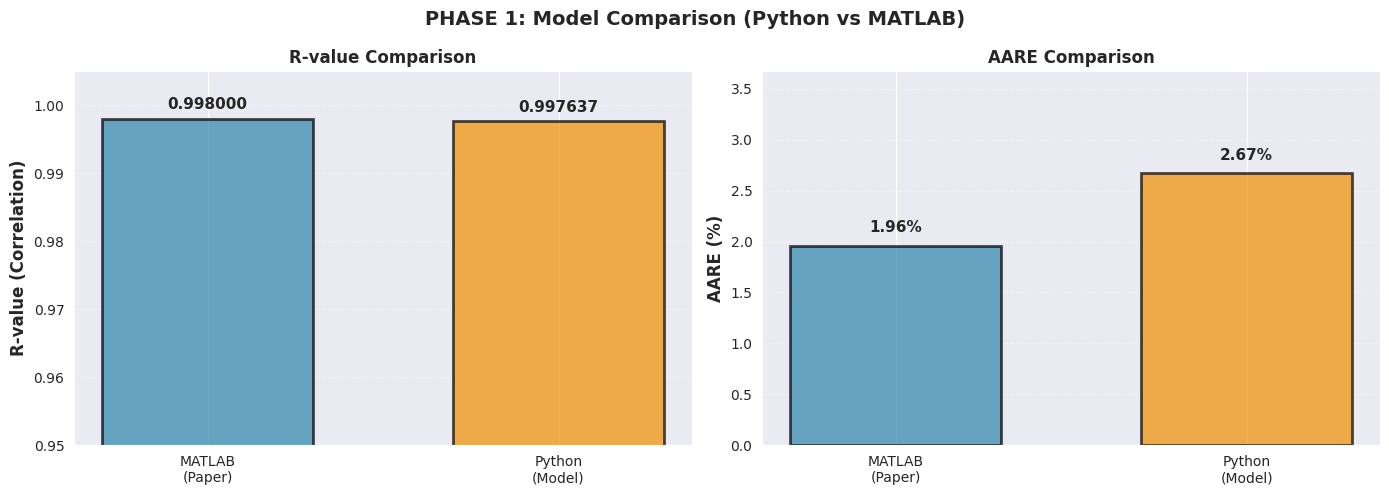

In [52]:
print("\n[PART 9] Model Comparison...")
print("-" * 90)

comparison_data = {
    'Model': ['MATLAB (Paper)', 'Python (Model)'],
    'R-value': [0.998, r_test],
    'AARE (%)': [1.96, aare_test],
    'R²': [0.996, r2_test],
    'MAE': ['N/A', f'{mae_test:.6f}'],
}

comparison_df = pd.DataFrame(comparison_data)
print("\nModel Comparison Table:")
print(comparison_df.to_string(index=False))

# Visualization comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('PHASE 1: Model Comparison (Python vs MATLAB)', fontsize=14, fontweight='bold')

# R-value comparison
models = ['MATLAB\n(Paper)', 'Python\n(Model)']
r_vals = [0.998, r_test]
colors = ['#2E86AB', '#F18F01']

bars1 = axes[0].bar(models, r_vals, color=colors, alpha=0.7, edgecolor='black', linewidth=2, width=0.6)
axes[0].set_ylabel('R-value (Correlation)', fontsize=12, fontweight='bold')
axes[0].set_title('R-value Comparison', fontsize=12, fontweight='bold')
axes[0].set_ylim([0.95, 1.005])
axes[0].grid(True, alpha=0.3, axis='y', linestyle='--')

for i, (bar, val) in enumerate(zip(bars1, r_vals)):
    axes[0].text(bar.get_x() + bar.get_width()/2, val + 0.001, f'{val:.6f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# AARE comparison
aare_vals = [1.96, aare_test]

bars2 = axes[1].bar(models, aare_vals, color=colors, alpha=0.7, edgecolor='black', linewidth=2, width=0.6)
axes[1].set_ylabel('AARE (%)', fontsize=12, fontweight='bold')
axes[1].set_title('AARE Comparison', fontsize=12, fontweight='bold')
axes[1].set_ylim([0, max(aare_vals) + 1])
axes[1].grid(True, alpha=0.3, axis='y', linestyle='--')

for i, (bar, val) in enumerate(zip(bars2, aare_vals)):
    axes[1].text(bar.get_x() + bar.get_width()/2, val + 0.1, f'{val:.2f}%',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('PHASE1_ModelComparison.png', dpi=300, bbox_inches='tight')
print("✓ Saved: PHASE1_ModelComparison.png")
plt.show()
plt.close()

In [53]:
print("\n" + "="*90)
print("PART 9: EXTRACTING MODEL WEIGHTS AND BIASES")
print("="*90)

print("\n TRAINED MODEL PARAMETERS:")
print("-"*90)

all_weights = {}
for i, layer in enumerate(model.layers):
    weights = layer.get_weights()
    if len(weights) > 0:
        W, b = weights[0], weights[1]
        all_weights[layer.name] = {'weights': W, 'biases': b}

        print(f"\n{layer.name.upper()}:")
        print(f"  Weights shape: {W.shape}")
        print(f"  Biases shape:  {b.shape}")
        print(f"  Total params:  {W.size + b.size}")
        print(f"  Weight range:  [{W.min():.6f}, {W.max():.6f}]")
        print(f"  Bias range:    [{b.min():.6f}, {b.max():.6f}]")

# Save weights to file
print("\n Saving weights to files...")
np.savez('model_weights.npz', **all_weights)
print("✓ Saved: model_weights.npz")



PART 9: EXTRACTING MODEL WEIGHTS AND BIASES

 TRAINED MODEL PARAMETERS:
------------------------------------------------------------------------------------------

HIDDEN_LAYER_1:
  Weights shape: (3, 10)
  Biases shape:  (10,)
  Total params:  40
  Weight range:  [-1.312889, 0.604809]
  Bias range:    [-0.179122, 0.193664]

HIDDEN_LAYER_2:
  Weights shape: (10, 10)
  Biases shape:  (10,)
  Total params:  110
  Weight range:  [-0.614187, 0.633785]
  Bias range:    [-0.054306, 0.051852]

OUTPUT_LAYER:
  Weights shape: (10, 1)
  Biases shape:  (1,)
  Total params:  11
  Weight range:  [-0.721343, 0.418416]
  Bias range:    [0.003564, 0.003564]

 Saving weights to files...
✓ Saved: model_weights.npz


In [55]:
print("\n[STEP 10] FINDING OPTIMAL INPUT VALUES...")
print("-" * 90)

print("""
OPTIMIZATION OBJECTIVES:

1. MAXIMUM STRESS CONDITIONS
   └─ Goal: Find inputs that produce highest flow stress
   └─ Use Case: Best strength/hardness conditions
   └─ Typical Result: Cold temperature, fast strain rate

2. MINIMUM STRESS CONDITIONS
   └─ Goal: Find inputs that produce lowest flow stress
   └─ Use Case: Best workability/ductility conditions
   └─ Typical Result: Hot temperature, slow strain rate

Algorithm: Differential Evolution
├─ Global optimization (avoids local minima)
├─ Bounded search: All inputs in [0, 1] normalized space
├─ 300 iterations for convergence
└─ Best solution found: x* = argmin/argmax f(x)
""")

def objective_maximize(X_norm):
    """Objective: Maximize stress"""
    X_input = X_norm.reshape(1, -1)
    stress_pred = model.predict(X_input, verbose=0)[0, 0]
    return -stress_pred  # Negative because scipy minimizes

def objective_minimize(X_norm):
    """Objective: Minimize stress"""
    X_input = X_norm.reshape(1, -1)
    stress_pred = model.predict(X_input, verbose=0)[0, 0]
    return stress_pred

# Bounds: all inputs normalized in [0, 1]
bounds = [(0, 1), (0, 1), (0, 1)]

print("\n→ Optimizing for MAXIMUM STRESS...")
result_max = differential_evolution(objective_maximize, bounds, seed=42, maxiter=300, verbose=0, workers=1)
optimal_max_norm = result_max.x
max_stress_norm = -result_max.fun

# Denormalize
optimal_max_denorm = scaler_X.inverse_transform(optimal_max_norm.reshape(1, -1))[0]
max_stress_denorm = scaler_y.inverse_transform([[max_stress_norm]])[0, 0]

print("\n→ Optimizing for MINIMUM STRESS...")
result_min = differential_evolution(objective_minimize, bounds, seed=42, maxiter=300, verbose=0, workers=1)
optimal_min_norm = result_min.x
min_stress_norm = result_min.fun

# Denormalize
optimal_min_denorm = scaler_X.inverse_transform(optimal_min_norm.reshape(1, -1))[0]
min_stress_denorm = scaler_y.inverse_transform([[min_stress_norm]])[0, 0]

print("✓ Optimization complete")


[STEP 10] FINDING OPTIMAL INPUT VALUES...
------------------------------------------------------------------------------------------

OPTIMIZATION OBJECTIVES:

1. MAXIMUM STRESS CONDITIONS
   └─ Goal: Find inputs that produce highest flow stress
   └─ Use Case: Best strength/hardness conditions
   └─ Typical Result: Cold temperature, fast strain rate

2. MINIMUM STRESS CONDITIONS
   └─ Goal: Find inputs that produce lowest flow stress
   └─ Use Case: Best workability/ductility conditions
   └─ Typical Result: Hot temperature, slow strain rate

Algorithm: Differential Evolution
├─ Global optimization (avoids local minima)
├─ Bounded search: All inputs in [0, 1] normalized space
├─ 300 iterations for convergence
└─ Best solution found: x* = argmin/argmax f(x)


→ Optimizing for MAXIMUM STRESS...


TypeError: differential_evolution() got an unexpected keyword argument 'verbose'